# Modeling Building<br/>*Creating an Interpretable Model*

## Goals
* Create small interpretable DecisionTrees that accurately represents the Titanic Data

## Interpretable Models
A model that is understandable can help domain experts understand their data.

Below a DecisionTree will be created:
* using 3 features and 5 leaf nodes
* using 4 features and 7 leaf nodes

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set() # enable seaborn style

import titanic_helper_code as tt
import itertools

In [2]:
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

In [3]:
# conda install python-graphviz
# pip install pydotplus
import graphviz
import pydotplus
from graphviz import Source

In [4]:
cv_select = RepeatedStratifiedKFold(n_splits=2, n_repeats=10, 
                                    random_state=108)

In [5]:
X, y = tt.get_Xy_v5()
X.columns.to_list()

['Pclass',
 'Sex',
 'Age',
 'Fare',
 'family_size',
 'is_cabin_notnull',
 'Port_C',
 'Port_Q',
 'Port_S',
 'Title_Master',
 'Title_Miss',
 'Title_Mr',
 'Title_Mrs',
 'Title_Other']

## Create Interpretable Decision Tree
1. Do not perform data preprocessing
   * except to impute missing age values
2. Limit number of leaf nodes
3. Limit number of features

### Use 3 Features with 5 Leaf Notes

In [6]:
# get all possible combinations of the 14 fields taken 3 at a time
subsets = list(itertools.combinations(X.columns, r=3))
len(subsets)

364

The get_ct_bycolumn returns a ColumnTransformer that selects a subset of the columns, and if that subset includes Age, it imputes missing values using the new IterativeImputer.  See titanic_helper_code.py in this directory.

In [7]:
# create a default Decision Tree with 5 leaf nodes
# for each combination of 3 fields
results = []
for s in subsets:
    
    cols_returned, ct = tt.get_ct_bycolumn(list(s))    
    dtree = DecisionTreeClassifier(max_leaf_nodes=5, random_state=707)
    pipe = Pipeline([('ct', ct), ('dtree', dtree)])
    scores = cross_val_score(pipe, X, y, cv=cv_select)
    results.append((scores.mean(), scores.std(), s))
    
results3_df = pd.DataFrame(results, columns=['scores', 'sd', 'vars'])    

In [8]:
results3_df.nlargest(n=5, columns=['scores'])

,scores,sd,vars
103,0.826707,0.014232,"(Sex, family_size, Title_Master)"
39,0.821435,0.014905,"(Pclass, family_size, Title_Mr)"
105,0.819750,0.014046,"(Sex, family_size, Title_Mr)"
249,0.818405,0.014102,"(family_size, is_cabin_notnull, Title_Mr)"
256,0.818405,0.014332,"(family_size, Port_C, Title_Mr)"


Recreate the above best tree, and fit it to all the data.

In [9]:
dtree = DecisionTreeClassifier(max_leaf_nodes=5, random_state=707)

X_prime = X[['Sex', 'Title_Master', 'family_size']]

scores = cross_val_score(dtree, X_prime, y, cv=cv_select)
tt.print_scores(scores)

dtree.fit(X_prime, y);

20 Scores  min:0.798 max:0.854
CV Mean Score: 0.827 +/- 0.014


Plot the Tree using graphviz.

The following requires:
1. conda install python-graphviz
2. pip install pydotplus

pydotplus is only used to adjust the size of the plot.

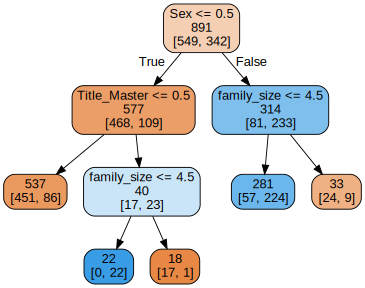

In [10]:
dot_data = export_graphviz(dtree, out_file=None, feature_names=X_prime.columns,
                                label=None, filled=True, impurity=False,
                                rounded=True)
pydot_graph = pydotplus.graph_from_dot_data(dot_data)

# adjust the plot size
pydot_graph.set_size('"6,4!"')

# display the Decision Treee
Source(pydot_graph.to_string())

### Tree Interpretation
The left branch is always True, the right is always False.
'Master' is the title given to boys.
Sex == 0  => male
Sex == 1  => female
Title_Master == 0  => title is not 'Master'
Title_Master == 1  => title is 'Master'

Rules in above Tree:
1. males that have a title of Master
   * from small families, 100% survived
   * from large families,   6% survived
2. males without the title of Master, 16% survived
3. women
   * from small families, 80% survived
   * from large families, 27% survived

"Small Family" is used above to mean a size of 4 or less.
"Large Family" is used above to mean a size of 5 or more.

Crew members were ordered to give women and children preference, so the above is reasonable.

87% of people from large families were 3rd class passengers, which helps to explain why so few members of large families survived.

In [27]:
X[X['family_size'] > 4]['Pclass'].value_counts()

3    54
1     6
2     2
Name: Pclass, dtype: int64

### Use 4 Features with 7 Leaf Notes

In [13]:
# get all possible combinations of the 14 fields taken 4 at a time
subsets = list(itertools.combinations(X.columns, r=4))
len(subsets)

1001

In [14]:
results = []
for s in subsets:
    
    cols_returned, ct = tt.get_ct_bycolumn(list(s))    
    dtree = DecisionTreeClassifier(max_leaf_nodes=7, random_state=707)
    pipe = Pipeline([('ct', ct), ('dtree', dtree)])
    scores = cross_val_score(pipe, X, y, cv=cv_select)
    results.append((scores.mean(), scores.std(), s))
    
results4_df = pd.DataFrame(results, columns=['scores', 'sd', 'vars'])    

In [19]:
results4_df.nlargest(n=5, columns=['scores'])

,scores,sd,vars
817,0.828615,0.014045,"(family_size, is_cabin_notnull, Title_Mr, Titl..."
25,0.828508,0.016442,"(Pclass, Sex, family_size, Title_Master)"
396,0.827043,0.015014,"(Sex, family_size, Port_C, Title_Master)"
420,0.826931,0.013509,"(Sex, family_size, Title_Mr, Title_Other)"
413,0.826595,0.013179,"(Sex, family_size, Title_Master, Title_Mr)"


In [24]:
pd.set_option('max_colwidth', 55)
results4_df.nlargest(n=2, columns=['scores'])['vars']

817    (family_size, is_cabin_notnull, Title_Mr, Title_Other)
25                   (Pclass, Sex, family_size, Title_Master)
Name: vars, dtype: object

The top two scores are nearly identical.  The second set of variables is easier to interpret.

Recreate the second best tree and fit it to all the data.

In [25]:
dtree = DecisionTreeClassifier(max_leaf_nodes=7, random_state=707)

X_prime = X[['Pclass', 'Sex', 'family_size', 'Title_Master']]
scores = cross_val_score(dtree, X_prime, y, cv=cv_select)
tt.print_scores(scores)

dtree.fit(X_prime, y);

20 Scores  min:0.791 max:0.859
CV Mean Score: 0.829 +/- 0.016


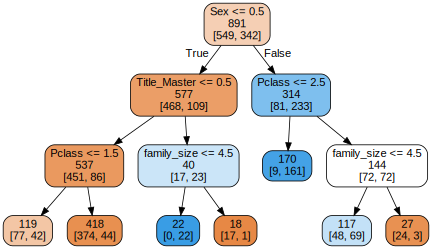

In [26]:
dot_data = export_graphviz(dtree, out_file=None, feature_names=X_prime.columns,
                                label=None, filled=True, impurity=False,
                                rounded=True)
pydot_graph = pydotplus.graph_from_dot_data(dot_data)

# adjust the plot size
pydot_graph.set_size('"6,4!"')

# display the Decision Treee
Source(pydot_graph.to_string())

### Tree Interpretation
Rules in above Tree:
1. Males without the title of 'Master'
   * in first class, 35% survived
   * in second or third class, 11% survived
2. Males with the title of 'Master'
   * from small families, 100% survived
   * from large families, 6% survived
3. Women in first or second class, 95% survived
4. Women in third class
   * from small families, 59% survived
   * from large families, 11% survived
   
The above tree performs about the same as the first tree, but gives some further insights.  Family Size is not just a surrogate for 3rd class, as women in 3rd class had very different survival rates depending upon whether or not they were from large families.

It appears that families stayed together.  There were insufficient life boats with insufficient room.  If families stayed together, then a large family would have found it difficult to board a life boat as an entire family.

## Notebook Summary
An small, easy to interpret, accurate DecisionTree was created to better understand the Titanic data.